# Importing Libiraries 📚

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import os
os.environ["TF_METAL_ENABLED"] = "1"

if os.environ.get("TF_METAL_ENABLED") == "1":
    print('Metal GPU Activated')
else:
    print('CPU being used')

Metal GPU Activated


# Define some functions  📡

In [150]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()
    
    
def preprocess(imgs):
        """
        Normalize and reshape the images
        """
        imgs = imgs.astype("float32") / 255.0
        imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
        imgs = np.expand_dims(imgs, -1)
        return imgs
def preprocess_forWGAN(img):
    """
    Noramzlizing image values and reshape the images
    """
    img = (tf.cast(img , "float32") - 127.5) / 127.5
    return img 


# Define and preprocess Data 🚧

In [151]:
train = pd.read_csv("archive/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

In [152]:
test = pd.read_csv("archive/fashion-mnist_test.csv")
test_x = test[list(test.columns)[1:]].values
test_y = test['label'].values

In [153]:
train_x = train_x.reshape(60000, 28 , 28)
x_train = np.array(train_x)

In [154]:
test_x = test_x.reshape(10000, 28 , 28)
text_x = np.array(test_x)

In [155]:

x_train = preprocess(train_x)
x_test = preprocess(test_x)

In [156]:
x_train.shape

(60000, 32, 32, 1)

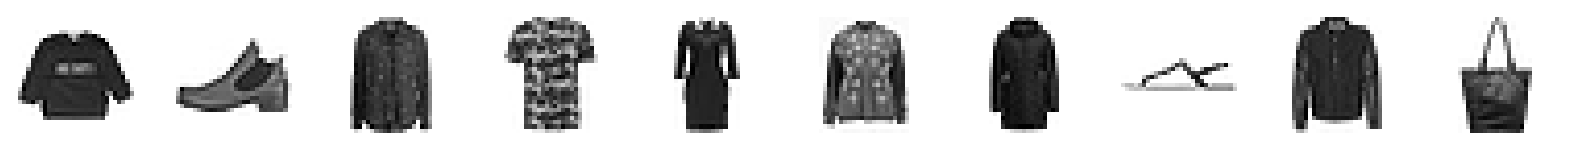

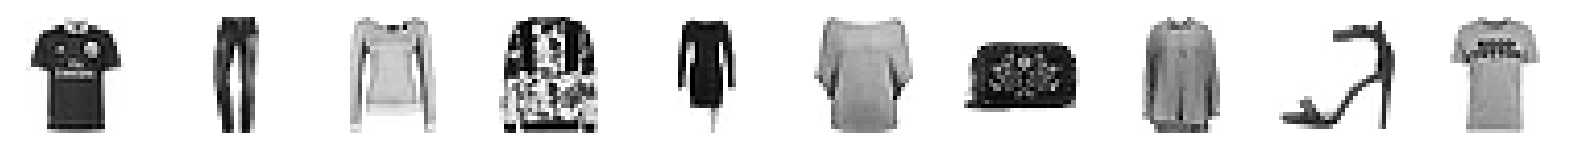

In [157]:
display(x_train)
display(x_test)

# 1. Variational Auto encoder model Building 🏗

## 1-1 Building Sampling Layer 🚧

In [11]:
#--> Sampling Layer
class Sampling(layers.Layer):
      def call(self , input):
        z_mean , z_log_var = input
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch , dim))
        return z_mean + epsilon * tf.exp(0.5 * z_log_var)

## 1-2 Building the encoder 🚧


In [12]:
#--> Encoder

encoder_input = layers.Input(shape = (32 , 32 , 1) , name = 'encoder_input')
x = layers.Conv2D(32 , 3 , strides = 2 , activation = 'relu' , padding = 'same')(encoder_input)
x = layers.Conv2D(64 , 3 , strides = 2 , activation = 'relu' , padding = 'same')(x)
x = layers.Conv2D(128 , 3 ,strides = 2 , activation = 'relu' , padding = 'same')(x)

shape_before_Flatting = K.int_shape(x)[1:] #--> We will need this in the decoder side
x = layers.Flatten()(x)
z_mean = layers.Dense(2 , name = "z_mean")(x)
z_log_var = layers.Dense(2 , name = "z_log_var")(x)
z = Sampling()([z_mean  , z_log_var])

encoder = models.Model(encoder_input , [z_mean , z_log_var , z] , name = "encoder")
encoder.summary()

2024-03-18 19:37:40.451085: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-03-18 19:37:40.451125: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-03-18 19:37:40.451137: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-03-18 19:37:40.451599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-18 19:37:40.451942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

## 1-3 Building the Decoder🚧

In [13]:
#----> Building the decoder
decoder_input = layers.Input(shape = (2 , ) , name = "Decoder_inputs")
x = layers.Dense(np.prod(shape_before_Flatting))(decoder_input)
x = layers.Reshape(shape_before_Flatting)(x)
x = layers.Conv2DTranspose(128 , 3 , strides = 2 , padding = 'same' , activation = 'relu')(x)
x = layers.Conv2DTranspose(64 , 3 , strides = 2 , padding = 'same' , activation = 'relu')(x)
x = layers.Conv2DTranspose(32 , 3 , strides = 2 , padding = 'same' , activation = 'relu')(x)
decoder_outputs = layers.Conv2D(1 , 3 , strides = 1 , padding = 'same' , activation = 'sigmoid' , name = 'decoder_outputs')(x)
decoder = models.Model(decoder_input , decoder_outputs)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_inputs (InputLayer  [(None, 2)]               0         
 )                                                               
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                             

## 1-4 Buildint the variational autoencoder class 🚧

In [14]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [15]:
#Define the autoencoder
vae = VAE(encoder, decoder)

## Compile and fit the VAE🚧

In [16]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [17]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/model-{epoch:02d}.keras",    
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

In [19]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 150
BETA = 500

In [20]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

history = vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/150


2024-03-18 19:37:54.453913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-18 19:37:54.513858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


596/600 [============================>.] - ETA: 0s - total_loss: 159.0087 - reconstruction_loss: 154.5336 - kl_loss: 4.4751WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 7s 10ms/step - total_loss: 158.8689 - reconstruction_loss: 154.3921 - kl_loss: 4.4768
Epoch 2/150
595/600 [============================>.] - ETA: 0s - total_loss: 135.4188 - reconstruction_loss: 130.6253 - kl_loss: 4.7935WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 135.4126 - reconstruction_loss: 130.6187 - kl_loss: 4.7939
Epoch 3/150
599/600 [============================>.] - ETA: 0s - total_loss: 133.9870 - reconstruction_loss: 129.1372 - kl_loss: 4.8497WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 133.9921 - reconstruction_loss: 129.1424 - kl_loss: 4.8495
Epoch 4/150
598/600 [============================>.] - ETA: 0s - total_loss: 133.2342 - reconstruction_loss: 128.3315 - kl_loss: 4.9026WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 133.2453 - reconstruction_loss: 128.3428 - kl_loss: 4.9025
Epoch 5/150
600/600 [==============================] - ETA: 0s - total_loss: 132.7352 - reconstruction_loss: 127.7702 - kl_loss: 4.9652WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 132.7352 - reconstruction_loss: 127.7702 - kl_loss: 4.9652
Epoch 6/150
598/600 [============================>.] - ETA: 0s - total_loss: 132.3413 - reconstruction_loss: 127.3267 - kl_loss: 5.0146WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 132.3296 - reconstruction_loss: 127.3151 - kl_loss: 5.0145
Epoch 7/150
596/600 [============================>.] - ETA: 0s - total_loss: 132.0362 - reconstruction_loss: 126.9968 - kl_loss: 5.0393WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 132.0220 - reconstruction_loss: 126.9822 - kl_loss: 5.0397
Epoch 8/150
596/600 [============================>.] - ETA: 0s - total_loss: 131.7546 - reconstruction_loss: 126.6796 - kl_loss: 5.0751WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 131.7538 - reconstruction_loss: 126.6788 - kl_loss: 5.0750
Epoch 9/150
599/600 [============================>.] - ETA: 0s - total_loss: 131.5245 - reconstruction_loss: 126.4077 - kl_loss: 5.1169WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 131.5290 - reconstruction_loss: 126.4120 - kl_loss: 5.1172
Epoch 10/150
597/600 [============================>.] - ETA: 0s - total_loss: 131.3401 - reconstruction_loss: 126.2026 - kl_loss: 5.1374WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 131.3241 - reconstruction_loss: 126.1857 - kl_loss: 5.1383
Epoch 11/150
597/600 [============================>.] - ETA: 0s - total_loss: 131.1505 - reconstruction_loss: 125.9911 - kl_loss: 5.1596WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 131.1661 - reconstruction_loss: 126.0064 - kl_loss: 5.1598
Epoch 12/150
597/600 [============================>.] - ETA: 0s - total_loss: 131.0284 - reconstruction_loss: 125.8512 - kl_loss: 5.1771WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 131.0201 - reconstruction_loss: 125.8430 - kl_loss: 5.1771
Epoch 13/150
597/600 [============================>.] - ETA: 0s - total_loss: 130.8320 - reconstruction_loss: 125.6361 - kl_loss: 5.1959WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.8310 - reconstruction_loss: 125.6354 - kl_loss: 5.1955
Epoch 14/150
599/600 [============================>.] - ETA: 0s - total_loss: 130.7133 - reconstruction_loss: 125.4973 - kl_loss: 5.2160WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.7048 - reconstruction_loss: 125.4890 - kl_loss: 5.2159
Epoch 15/150
596/600 [============================>.] - ETA: 0s - total_loss: 130.5651 - reconstruction_loss: 125.3330 - kl_loss: 5.2320WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.5722 - reconstruction_loss: 125.3394 - kl_loss: 5.2327
Epoch 16/150
596/600 [============================>.] - ETA: 0s - total_loss: 130.4811 - reconstruction_loss: 125.2199 - kl_loss: 5.2612WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.4866 - reconstruction_loss: 125.2251 - kl_loss: 5.2616
Epoch 17/150
598/600 [============================>.] - ETA: 0s - total_loss: 130.3481 - reconstruction_loss: 125.0730 - kl_loss: 5.2750WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.3433 - reconstruction_loss: 125.0680 - kl_loss: 5.2752
Epoch 18/150
599/600 [============================>.] - ETA: 0s - total_loss: 130.2337 - reconstruction_loss: 124.9428 - kl_loss: 5.2910WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.2298 - reconstruction_loss: 124.9390 - kl_loss: 5.2909
Epoch 19/150
596/600 [============================>.] - ETA: 0s - total_loss: 130.1184 - reconstruction_loss: 124.8314 - kl_loss: 5.2869WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.1090 - reconstruction_loss: 124.8216 - kl_loss: 5.2874
Epoch 20/150
599/600 [============================>.] - ETA: 0s - total_loss: 130.0561 - reconstruction_loss: 124.7480 - kl_loss: 5.3081WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 130.0525 - reconstruction_loss: 124.7441 - kl_loss: 5.3084
Epoch 21/150
596/600 [============================>.] - ETA: 0s - total_loss: 129.9219 - reconstruction_loss: 124.5927 - kl_loss: 5.3293WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.9312 - reconstruction_loss: 124.6019 - kl_loss: 5.3293
Epoch 22/150
595/600 [============================>.] - ETA: 0s - total_loss: 129.8005 - reconstruction_loss: 124.4729 - kl_loss: 5.3277WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.8352 - reconstruction_loss: 124.5072 - kl_loss: 5.3280
Epoch 23/150
600/600 [==============================] - ETA: 0s - total_loss: 129.7504 - reconstruction_loss: 124.3955 - kl_loss: 5.3549WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.7504 - reconstruction_loss: 124.3955 - kl_loss: 5.3549
Epoch 24/150
598/600 [============================>.] - ETA: 0s - total_loss: 129.6836 - reconstruction_loss: 124.3260 - kl_loss: 5.3576WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.6736 - reconstruction_loss: 124.3165 - kl_loss: 5.3571
Epoch 25/150
597/600 [============================>.] - ETA: 0s - total_loss: 129.6044 - reconstruction_loss: 124.2244 - kl_loss: 5.3801WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 11ms/step - total_loss: 129.6263 - reconstruction_loss: 124.2462 - kl_loss: 5.3802
Epoch 26/150
596/600 [============================>.] - ETA: 0s - total_loss: 129.4857 - reconstruction_loss: 124.1011 - kl_loss: 5.3846WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.5040 - reconstruction_loss: 124.1201 - kl_loss: 5.3839
Epoch 27/150
600/600 [==============================] - ETA: 0s - total_loss: 129.4364 - reconstruction_loss: 124.0377 - kl_loss: 5.3986WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.4364 - reconstruction_loss: 124.0377 - kl_loss: 5.3986
Epoch 28/150
597/600 [============================>.] - ETA: 0s - total_loss: 129.3604 - reconstruction_loss: 123.9447 - kl_loss: 5.4157WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.3499 - reconstruction_loss: 123.9343 - kl_loss: 5.4155
Epoch 29/150
599/600 [============================>.] - ETA: 0s - total_loss: 129.2821 - reconstruction_loss: 123.8605 - kl_loss: 5.4217WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 129.2897 - reconstruction_loss: 123.8681 - kl_loss: 5.4216
Epoch 30/150
595/600 [============================>.] - ETA: 0s - total_loss: 129.2121 - reconstruction_loss: 123.7891 - kl_loss: 5.4229WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 129.2303 - reconstruction_loss: 123.8070 - kl_loss: 5.4233
Epoch 31/150
598/600 [============================>.] - ETA: 0s - total_loss: 129.1980 - reconstruction_loss: 123.7624 - kl_loss: 5.4357WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.1983 - reconstruction_loss: 123.7628 - kl_loss: 5.4357
Epoch 32/150
595/600 [============================>.] - ETA: 0s - total_loss: 129.1273 - reconstruction_loss: 123.6754 - kl_loss: 5.4518WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.1157 - reconstruction_loss: 123.6640 - kl_loss: 5.4517
Epoch 33/150
599/600 [============================>.] - ETA: 0s - total_loss: 129.0754 - reconstruction_loss: 123.6250 - kl_loss: 5.4505WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 129.0688 - reconstruction_loss: 123.6183 - kl_loss: 5.4506
Epoch 34/150
596/600 [============================>.] - ETA: 0s - total_loss: 128.9848 - reconstruction_loss: 123.5139 - kl_loss: 5.4709WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.9858 - reconstruction_loss: 123.5155 - kl_loss: 5.4702
Epoch 35/150
600/600 [==============================] - ETA: 0s - total_loss: 128.9183 - reconstruction_loss: 123.4481 - kl_loss: 5.4702WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.9183 - reconstruction_loss: 123.4481 - kl_loss: 5.4702
Epoch 36/150
600/600 [==============================] - ETA: 0s - total_loss: 128.8958 - reconstruction_loss: 123.4130 - kl_loss: 5.4828WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.8958 - reconstruction_loss: 123.4130 - kl_loss: 5.4828
Epoch 37/150
598/600 [============================>.] - ETA: 0s - total_loss: 128.8352 - reconstruction_loss: 123.3453 - kl_loss: 5.4900WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.8444 - reconstruction_loss: 123.3537 - kl_loss: 5.4907
Epoch 38/150
595/600 [============================>.] - ETA: 0s - total_loss: 128.8155 - reconstruction_loss: 123.3255 - kl_loss: 5.4901WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.7941 - reconstruction_loss: 123.3039 - kl_loss: 5.4903
Epoch 39/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.7483 - reconstruction_loss: 123.2493 - kl_loss: 5.4989WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.7536 - reconstruction_loss: 123.2547 - kl_loss: 5.4988
Epoch 40/150
600/600 [==============================] - ETA: 0s - total_loss: 128.6797 - reconstruction_loss: 123.1781 - kl_loss: 5.5016WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.6797 - reconstruction_loss: 123.1781 - kl_loss: 5.5016
Epoch 41/150
595/600 [============================>.] - ETA: 0s - total_loss: 128.6577 - reconstruction_loss: 123.1397 - kl_loss: 5.5179WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.6692 - reconstruction_loss: 123.1522 - kl_loss: 5.5169
Epoch 42/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.5845 - reconstruction_loss: 123.0515 - kl_loss: 5.5329WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 128.5984 - reconstruction_loss: 123.0651 - kl_loss: 5.5332
Epoch 43/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.5464 - reconstruction_loss: 123.0106 - kl_loss: 5.5358WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.5484 - reconstruction_loss: 123.0128 - kl_loss: 5.5356
Epoch 44/150
597/600 [============================>.] - ETA: 0s - total_loss: 128.5101 - reconstruction_loss: 122.9720 - kl_loss: 5.5381WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.5206 - reconstruction_loss: 122.9830 - kl_loss: 5.5377
Epoch 45/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.4899 - reconstruction_loss: 122.9453 - kl_loss: 5.5446WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.4879 - reconstruction_loss: 122.9432 - kl_loss: 5.5446
Epoch 46/150
600/600 [==============================] - ETA: 0s - total_loss: 128.4447 - reconstruction_loss: 122.8953 - kl_loss: 5.5495WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.4447 - reconstruction_loss: 122.8953 - kl_loss: 5.5495
Epoch 47/150
600/600 [==============================] - ETA: 0s - total_loss: 128.3803 - reconstruction_loss: 122.8260 - kl_loss: 5.5543WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.3803 - reconstruction_loss: 122.8260 - kl_loss: 5.5543
Epoch 48/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.3687 - reconstruction_loss: 122.8064 - kl_loss: 5.5623WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.3846 - reconstruction_loss: 122.8224 - kl_loss: 5.5623
Epoch 49/150
600/600 [==============================] - ETA: 0s - total_loss: 128.3274 - reconstruction_loss: 122.7512 - kl_loss: 5.5762WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.3274 - reconstruction_loss: 122.7512 - kl_loss: 5.5762
Epoch 50/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.2784 - reconstruction_loss: 122.7031 - kl_loss: 5.5752WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.2770 - reconstruction_loss: 122.7017 - kl_loss: 5.5753
Epoch 51/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.2414 - reconstruction_loss: 122.6565 - kl_loss: 5.5850WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.2308 - reconstruction_loss: 122.6455 - kl_loss: 5.5854
Epoch 52/150
598/600 [============================>.] - ETA: 0s - total_loss: 128.2039 - reconstruction_loss: 122.6133 - kl_loss: 5.5906WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.2170 - reconstruction_loss: 122.6262 - kl_loss: 5.5908
Epoch 53/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.2169 - reconstruction_loss: 122.6216 - kl_loss: 5.5954WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.2104 - reconstruction_loss: 122.6150 - kl_loss: 5.5955
Epoch 54/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.1555 - reconstruction_loss: 122.5644 - kl_loss: 5.5911WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.1513 - reconstruction_loss: 122.5603 - kl_loss: 5.5911
Epoch 55/150
600/600 [==============================] - ETA: 0s - total_loss: 128.0759 - reconstruction_loss: 122.4785 - kl_loss: 5.5973WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.0759 - reconstruction_loss: 122.4785 - kl_loss: 5.5973
Epoch 56/150
600/600 [==============================] - ETA: 0s - total_loss: 128.1028 - reconstruction_loss: 122.4865 - kl_loss: 5.6164WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.1028 - reconstruction_loss: 122.4865 - kl_loss: 5.6164
Epoch 57/150
599/600 [============================>.] - ETA: 0s - total_loss: 128.0362 - reconstruction_loss: 122.4254 - kl_loss: 5.6109WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 128.0485 - reconstruction_loss: 122.4377 - kl_loss: 5.6108
Epoch 58/150
596/600 [============================>.] - ETA: 0s - total_loss: 128.0086 - reconstruction_loss: 122.3863 - kl_loss: 5.6225WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.9991 - reconstruction_loss: 122.3768 - kl_loss: 5.6225
Epoch 59/150
598/600 [============================>.] - ETA: 0s - total_loss: 128.0010 - reconstruction_loss: 122.3811 - kl_loss: 5.6200WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.9985 - reconstruction_loss: 122.3781 - kl_loss: 5.6205
Epoch 60/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.9674 - reconstruction_loss: 122.3435 - kl_loss: 5.6241WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.9696 - reconstruction_loss: 122.3458 - kl_loss: 5.6239
Epoch 61/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.9139 - reconstruction_loss: 122.2833 - kl_loss: 5.6305WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.9189 - reconstruction_loss: 122.2884 - kl_loss: 5.6304
Epoch 62/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.8929 - reconstruction_loss: 122.2552 - kl_loss: 5.6377WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.8882 - reconstruction_loss: 122.2504 - kl_loss: 5.6378
Epoch 63/150
598/600 [============================>.] - ETA: 0s - total_loss: 127.8422 - reconstruction_loss: 122.2067 - kl_loss: 5.6356WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.8449 - reconstruction_loss: 122.2096 - kl_loss: 5.6354
Epoch 64/150
600/600 [==============================] - ETA: 0s - total_loss: 127.8417 - reconstruction_loss: 122.1929 - kl_loss: 5.6488WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.8417 - reconstruction_loss: 122.1929 - kl_loss: 5.6488
Epoch 65/150
600/600 [==============================] - ETA: 0s - total_loss: 127.8290 - reconstruction_loss: 122.1756 - kl_loss: 5.6534WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.8290 - reconstruction_loss: 122.1756 - kl_loss: 5.6534
Epoch 66/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.8160 - reconstruction_loss: 122.1690 - kl_loss: 5.6470WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.8104 - reconstruction_loss: 122.1636 - kl_loss: 5.6468
Epoch 67/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.7687 - reconstruction_loss: 122.1134 - kl_loss: 5.6553WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.7725 - reconstruction_loss: 122.1172 - kl_loss: 5.6553
Epoch 68/150
600/600 [==============================] - ETA: 0s - total_loss: 127.7075 - reconstruction_loss: 122.0455 - kl_loss: 5.6620WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.7075 - reconstruction_loss: 122.0455 - kl_loss: 5.6620
Epoch 69/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.7154 - reconstruction_loss: 122.0484 - kl_loss: 5.6670WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.7225 - reconstruction_loss: 122.0553 - kl_loss: 5.6672
Epoch 70/150
597/600 [============================>.] - ETA: 0s - total_loss: 127.6863 - reconstruction_loss: 122.0082 - kl_loss: 5.6781WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.6793 - reconstruction_loss: 122.0014 - kl_loss: 5.6780
Epoch 71/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.6506 - reconstruction_loss: 121.9771 - kl_loss: 5.6736WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.6620 - reconstruction_loss: 121.9883 - kl_loss: 5.6738
Epoch 72/150
597/600 [============================>.] - ETA: 0s - total_loss: 127.6732 - reconstruction_loss: 121.9929 - kl_loss: 5.6804WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.6733 - reconstruction_loss: 121.9935 - kl_loss: 5.6799
Epoch 73/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.6393 - reconstruction_loss: 121.9490 - kl_loss: 5.6905WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.6442 - reconstruction_loss: 121.9536 - kl_loss: 5.6906
Epoch 74/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.5788 - reconstruction_loss: 121.8868 - kl_loss: 5.6920WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.5870 - reconstruction_loss: 121.8947 - kl_loss: 5.6923
Epoch 75/150
600/600 [==============================] - ETA: 0s - total_loss: 127.5614 - reconstruction_loss: 121.8630 - kl_loss: 5.6984WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.5614 - reconstruction_loss: 121.8630 - kl_loss: 5.6984
Epoch 76/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.5676 - reconstruction_loss: 121.8706 - kl_loss: 5.6971WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.5699 - reconstruction_loss: 121.8727 - kl_loss: 5.6972
Epoch 77/150
600/600 [==============================] - ETA: 0s - total_loss: 127.5223 - reconstruction_loss: 121.8185 - kl_loss: 5.7038WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.5223 - reconstruction_loss: 121.8185 - kl_loss: 5.7038
Epoch 78/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.5189 - reconstruction_loss: 121.8064 - kl_loss: 5.7124WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.5120 - reconstruction_loss: 121.7995 - kl_loss: 5.7124
Epoch 79/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.4675 - reconstruction_loss: 121.7617 - kl_loss: 5.7058WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.4606 - reconstruction_loss: 121.7547 - kl_loss: 5.7059
Epoch 80/150
600/600 [==============================] - ETA: 0s - total_loss: 127.4827 - reconstruction_loss: 121.7711 - kl_loss: 5.7116WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.4827 - reconstruction_loss: 121.7711 - kl_loss: 5.7116
Epoch 81/150
596/600 [============================>.] - ETA: 0s - total_loss: 127.4407 - reconstruction_loss: 121.7270 - kl_loss: 5.7137WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.4405 - reconstruction_loss: 121.7266 - kl_loss: 5.7138
Epoch 82/150
596/600 [============================>.] - ETA: 0s - total_loss: 127.4134 - reconstruction_loss: 121.6988 - kl_loss: 5.7145WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.4112 - reconstruction_loss: 121.6958 - kl_loss: 5.7153
Epoch 83/150
600/600 [==============================] - ETA: 0s - total_loss: 127.4152 - reconstruction_loss: 121.6880 - kl_loss: 5.7273WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.4152 - reconstruction_loss: 121.6880 - kl_loss: 5.7273
Epoch 84/150
596/600 [============================>.] - ETA: 0s - total_loss: 127.4244 - reconstruction_loss: 121.6986 - kl_loss: 5.7258WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.4056 - reconstruction_loss: 121.6795 - kl_loss: 5.7262
Epoch 85/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.3598 - reconstruction_loss: 121.6334 - kl_loss: 5.7264WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.3637 - reconstruction_loss: 121.6372 - kl_loss: 5.7265
Epoch 86/150
597/600 [============================>.] - ETA: 0s - total_loss: 127.3854 - reconstruction_loss: 121.6490 - kl_loss: 5.7365WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.3870 - reconstruction_loss: 121.6507 - kl_loss: 5.7363
Epoch 87/150
598/600 [============================>.] - ETA: 0s - total_loss: 127.3461 - reconstruction_loss: 121.6178 - kl_loss: 5.7282WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.3505 - reconstruction_loss: 121.6221 - kl_loss: 5.7284
Epoch 88/150
596/600 [============================>.] - ETA: 0s - total_loss: 127.3399 - reconstruction_loss: 121.6045 - kl_loss: 5.7355WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.3303 - reconstruction_loss: 121.5941 - kl_loss: 5.7363
Epoch 89/150
600/600 [==============================] - ETA: 0s - total_loss: 127.3058 - reconstruction_loss: 121.5684 - kl_loss: 5.7375WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.3058 - reconstruction_loss: 121.5684 - kl_loss: 5.7375
Epoch 90/150
596/600 [============================>.] - ETA: 0s - total_loss: 127.3084 - reconstruction_loss: 121.5728 - kl_loss: 5.7356WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.3118 - reconstruction_loss: 121.5763 - kl_loss: 5.7354
Epoch 91/150
598/600 [============================>.] - ETA: 0s - total_loss: 127.2426 - reconstruction_loss: 121.4966 - kl_loss: 5.7461WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.2492 - reconstruction_loss: 121.5032 - kl_loss: 5.7459
Epoch 92/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.2223 - reconstruction_loss: 121.4735 - kl_loss: 5.7489WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.2194 - reconstruction_loss: 121.4707 - kl_loss: 5.7489
Epoch 93/150
597/600 [============================>.] - ETA: 0s - total_loss: 127.2704 - reconstruction_loss: 121.5169 - kl_loss: 5.7534WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.2695 - reconstruction_loss: 121.5163 - kl_loss: 5.7532
Epoch 94/150
597/600 [============================>.] - ETA: 0s - total_loss: 127.2198 - reconstruction_loss: 121.4670 - kl_loss: 5.7526WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.2016 - reconstruction_loss: 121.4490 - kl_loss: 5.7525
Epoch 95/150
597/600 [============================>.] - ETA: 0s - total_loss: 127.2050 - reconstruction_loss: 121.4448 - kl_loss: 5.7603WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.1961 - reconstruction_loss: 121.4363 - kl_loss: 5.7599
Epoch 96/150
596/600 [============================>.] - ETA: 0s - total_loss: 127.2063 - reconstruction_loss: 121.4437 - kl_loss: 5.7627WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.2011 - reconstruction_loss: 121.4382 - kl_loss: 5.7630
Epoch 97/150
598/600 [============================>.] - ETA: 0s - total_loss: 127.1509 - reconstruction_loss: 121.3827 - kl_loss: 5.7683WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.1502 - reconstruction_loss: 121.3820 - kl_loss: 5.7682
Epoch 98/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.1570 - reconstruction_loss: 121.3865 - kl_loss: 5.7704WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.1624 - reconstruction_loss: 121.3918 - kl_loss: 5.7706
Epoch 99/150
595/600 [============================>.] - ETA: 0s - total_loss: 127.1403 - reconstruction_loss: 121.3781 - kl_loss: 5.7622WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.1295 - reconstruction_loss: 121.3668 - kl_loss: 5.7628
Epoch 100/150
600/600 [==============================] - ETA: 0s - total_loss: 127.1373 - reconstruction_loss: 121.3618 - kl_loss: 5.7755WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.1373 - reconstruction_loss: 121.3618 - kl_loss: 5.7755
Epoch 101/150
600/600 [==============================] - ETA: 0s - total_loss: 127.1270 - reconstruction_loss: 121.3544 - kl_loss: 5.7725WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.1270 - reconstruction_loss: 121.3544 - kl_loss: 5.7725
Epoch 102/150
596/600 [============================>.] - ETA: 0s - total_loss: 127.0943 - reconstruction_loss: 121.3181 - kl_loss: 5.7763WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 127.0834 - reconstruction_loss: 121.3076 - kl_loss: 5.7758
Epoch 103/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.1108 - reconstruction_loss: 121.3268 - kl_loss: 5.7840WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.1068 - reconstruction_loss: 121.3229 - kl_loss: 5.7839
Epoch 104/150
597/600 [============================>.] - ETA: 0s - total_loss: 127.0621 - reconstruction_loss: 121.2759 - kl_loss: 5.7863WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.0650 - reconstruction_loss: 121.2791 - kl_loss: 5.7860
Epoch 105/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.0425 - reconstruction_loss: 121.2483 - kl_loss: 5.7942WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.0424 - reconstruction_loss: 121.2482 - kl_loss: 5.7942
Epoch 106/150
600/600 [==============================] - ETA: 0s - total_loss: 127.0592 - reconstruction_loss: 121.2733 - kl_loss: 5.7858WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.0592 - reconstruction_loss: 121.2733 - kl_loss: 5.7858
Epoch 107/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.0368 - reconstruction_loss: 121.2439 - kl_loss: 5.7929WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.0338 - reconstruction_loss: 121.2411 - kl_loss: 5.7927
Epoch 108/150
599/600 [============================>.] - ETA: 0s - total_loss: 126.9831 - reconstruction_loss: 121.1926 - kl_loss: 5.7904WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 126.9798 - reconstruction_loss: 121.1892 - kl_loss: 5.7905
Epoch 109/150
600/600 [==============================] - ETA: 0s - total_loss: 127.0104 - reconstruction_loss: 121.2208 - kl_loss: 5.7897WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.0104 - reconstruction_loss: 121.2208 - kl_loss: 5.7897
Epoch 110/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.0391 - reconstruction_loss: 121.2520 - kl_loss: 5.7872WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.0231 - reconstruction_loss: 121.2357 - kl_loss: 5.7875
Epoch 111/150
599/600 [============================>.] - ETA: 0s - total_loss: 127.0038 - reconstruction_loss: 121.2048 - kl_loss: 5.7990WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 127.0015 - reconstruction_loss: 121.2027 - kl_loss: 5.7989
Epoch 112/150
600/600 [==============================] - ETA: 0s - total_loss: 126.9443 - reconstruction_loss: 121.1409 - kl_loss: 5.8034WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 126.9443 - reconstruction_loss: 121.1409 - kl_loss: 5.8034
Epoch 113/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.9960 - reconstruction_loss: 121.1868 - kl_loss: 5.8091WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 126.9819 - reconstruction_loss: 121.1727 - kl_loss: 5.8091
Epoch 114/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.9581 - reconstruction_loss: 121.1546 - kl_loss: 5.8036WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 126.9601 - reconstruction_loss: 121.1569 - kl_loss: 5.8032
Epoch 115/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.9206 - reconstruction_loss: 121.1153 - kl_loss: 5.8053WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.9064 - reconstruction_loss: 121.1003 - kl_loss: 5.8061
Epoch 116/150
600/600 [==============================] - ETA: 0s - total_loss: 126.9206 - reconstruction_loss: 121.1077 - kl_loss: 5.8129WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.9206 - reconstruction_loss: 121.1077 - kl_loss: 5.8129
Epoch 117/150
596/600 [============================>.] - ETA: 0s - total_loss: 126.8999 - reconstruction_loss: 121.0904 - kl_loss: 5.8095WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8870 - reconstruction_loss: 121.0773 - kl_loss: 5.8096
Epoch 118/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.8837 - reconstruction_loss: 121.0738 - kl_loss: 5.8099WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.9019 - reconstruction_loss: 121.0918 - kl_loss: 5.8100
Epoch 119/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.8629 - reconstruction_loss: 121.0498 - kl_loss: 5.8132WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8726 - reconstruction_loss: 121.0599 - kl_loss: 5.8128
Epoch 120/150
596/600 [============================>.] - ETA: 0s - total_loss: 126.8484 - reconstruction_loss: 121.0312 - kl_loss: 5.8172WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8712 - reconstruction_loss: 121.0537 - kl_loss: 5.8174
Epoch 121/150
598/600 [============================>.] - ETA: 0s - total_loss: 126.8487 - reconstruction_loss: 121.0244 - kl_loss: 5.8242WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8540 - reconstruction_loss: 121.0297 - kl_loss: 5.8242
Epoch 122/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.8436 - reconstruction_loss: 121.0164 - kl_loss: 5.8272WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8449 - reconstruction_loss: 121.0177 - kl_loss: 5.8273
Epoch 123/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.8561 - reconstruction_loss: 121.0320 - kl_loss: 5.8241WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8403 - reconstruction_loss: 121.0165 - kl_loss: 5.8238
Epoch 124/150
596/600 [============================>.] - ETA: 0s - total_loss: 126.8285 - reconstruction_loss: 120.9937 - kl_loss: 5.8349WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8108 - reconstruction_loss: 120.9762 - kl_loss: 5.8346
Epoch 125/150
599/600 [============================>.] - ETA: 0s - total_loss: 126.7964 - reconstruction_loss: 120.9700 - kl_loss: 5.8262WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8023 - reconstruction_loss: 120.9757 - kl_loss: 5.8265
Epoch 126/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.7785 - reconstruction_loss: 120.9378 - kl_loss: 5.8408WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7791 - reconstruction_loss: 120.9384 - kl_loss: 5.8408
Epoch 127/150
599/600 [============================>.] - ETA: 0s - total_loss: 126.8279 - reconstruction_loss: 120.9830 - kl_loss: 5.8448WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.8226 - reconstruction_loss: 120.9777 - kl_loss: 5.8447
Epoch 128/150
599/600 [============================>.] - ETA: 0s - total_loss: 126.7657 - reconstruction_loss: 120.9392 - kl_loss: 5.8266WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7596 - reconstruction_loss: 120.9327 - kl_loss: 5.8270
Epoch 129/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.7922 - reconstruction_loss: 120.9623 - kl_loss: 5.8300WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7875 - reconstruction_loss: 120.9573 - kl_loss: 5.8303
Epoch 130/150
596/600 [============================>.] - ETA: 0s - total_loss: 126.7514 - reconstruction_loss: 120.9190 - kl_loss: 5.8325WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7602 - reconstruction_loss: 120.9282 - kl_loss: 5.8321
Epoch 131/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.7370 - reconstruction_loss: 120.9027 - kl_loss: 5.8343WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7307 - reconstruction_loss: 120.8957 - kl_loss: 5.8351
Epoch 132/150
598/600 [============================>.] - ETA: 0s - total_loss: 126.7393 - reconstruction_loss: 120.8965 - kl_loss: 5.8428WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7261 - reconstruction_loss: 120.8832 - kl_loss: 5.8429
Epoch 133/150
596/600 [============================>.] - ETA: 0s - total_loss: 126.7262 - reconstruction_loss: 120.8861 - kl_loss: 5.8402WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7334 - reconstruction_loss: 120.8931 - kl_loss: 5.8404
Epoch 134/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.7261 - reconstruction_loss: 120.8859 - kl_loss: 5.8402WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7342 - reconstruction_loss: 120.8945 - kl_loss: 5.8397
Epoch 135/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.7265 - reconstruction_loss: 120.8739 - kl_loss: 5.8527WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7233 - reconstruction_loss: 120.8711 - kl_loss: 5.8522
Epoch 136/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.6974 - reconstruction_loss: 120.8512 - kl_loss: 5.8463WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6942 - reconstruction_loss: 120.8472 - kl_loss: 5.8470
Epoch 137/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.6967 - reconstruction_loss: 120.8433 - kl_loss: 5.8535WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.7101 - reconstruction_loss: 120.8555 - kl_loss: 5.8547
Epoch 138/150
598/600 [============================>.] - ETA: 0s - total_loss: 126.6738 - reconstruction_loss: 120.8180 - kl_loss: 5.8557WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6716 - reconstruction_loss: 120.8161 - kl_loss: 5.8555
Epoch 139/150
595/600 [============================>.] - ETA: 0s - total_loss: 126.6684 - reconstruction_loss: 120.8145 - kl_loss: 5.8539WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6726 - reconstruction_loss: 120.8190 - kl_loss: 5.8536
Epoch 140/150
599/600 [============================>.] - ETA: 0s - total_loss: 126.6846 - reconstruction_loss: 120.8267 - kl_loss: 5.8579WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6877 - reconstruction_loss: 120.8297 - kl_loss: 5.8580
Epoch 141/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.6642 - reconstruction_loss: 120.8054 - kl_loss: 5.8587WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6662 - reconstruction_loss: 120.8067 - kl_loss: 5.8594
Epoch 142/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.6639 - reconstruction_loss: 120.8076 - kl_loss: 5.8564WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6514 - reconstruction_loss: 120.7951 - kl_loss: 5.8564
Epoch 143/150
600/600 [==============================] - ETA: 0s - total_loss: 126.6311 - reconstruction_loss: 120.7659 - kl_loss: 5.8651WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6311 - reconstruction_loss: 120.7659 - kl_loss: 5.8651
Epoch 144/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.6639 - reconstruction_loss: 120.7960 - kl_loss: 5.8679WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6507 - reconstruction_loss: 120.7828 - kl_loss: 5.8680
Epoch 145/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.6510 - reconstruction_loss: 120.7921 - kl_loss: 5.8589WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.6413 - reconstruction_loss: 120.7824 - kl_loss: 5.8588
Epoch 146/150
597/600 [============================>.] - ETA: 0s - total_loss: 126.6006 - reconstruction_loss: 120.7305 - kl_loss: 5.8700WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 126.5981 - reconstruction_loss: 120.7279 - kl_loss: 5.8701
Epoch 147/150
600/600 [==============================] - ETA: 0s - total_loss: 126.5955 - reconstruction_loss: 120.7221 - kl_loss: 5.8735WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.5955 - reconstruction_loss: 120.7221 - kl_loss: 5.8735
Epoch 148/150
598/600 [============================>.] - ETA: 0s - total_loss: 126.5935 - reconstruction_loss: 120.7234 - kl_loss: 5.8701WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 10ms/step - total_loss: 126.5864 - reconstruction_loss: 120.7159 - kl_loss: 5.8704
Epoch 149/150
600/600 [==============================] - ETA: 0s - total_loss: 126.5820 - reconstruction_loss: 120.7120 - kl_loss: 5.8701WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 126.5820 - reconstruction_loss: 120.7120 - kl_loss: 5.8701
Epoch 150/150
598/600 [============================>.] - ETA: 0s - total_loss: 126.5649 - reconstruction_loss: 120.6812 - kl_loss: 5.8837WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 6s 9ms/step - total_loss: 126.5693 - reconstruction_loss: 120.6860 - kl_loss: 5.8834


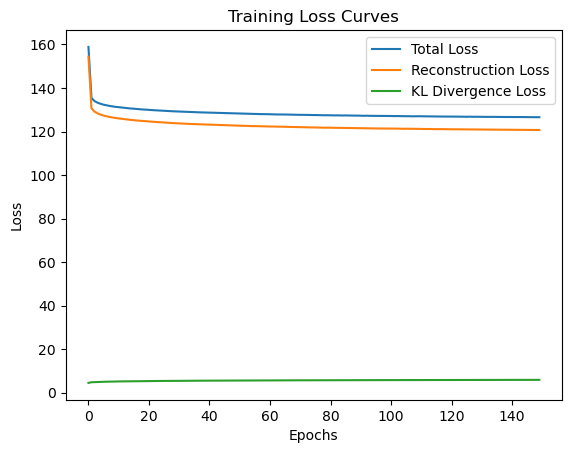

1875/1875 [==============================] - 2s 809us/step


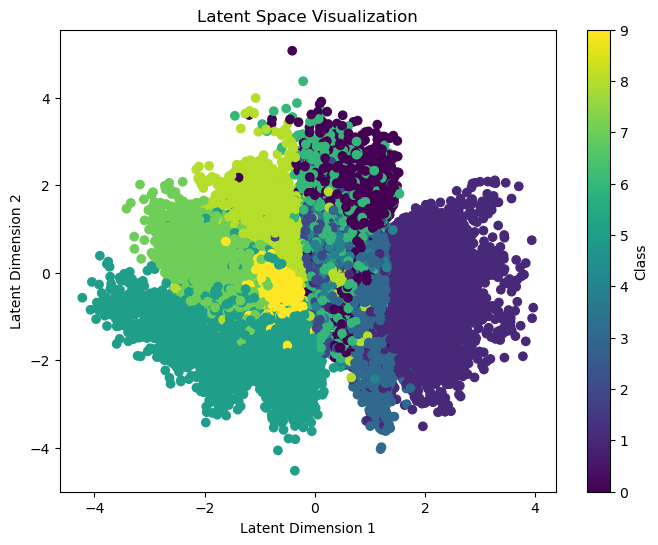

1/1 [==============================] - 0s 249ms/step


AttributeError: 'tuple' object has no attribute 'max'

In [21]:
# Plot loss curves
plt.plot(history.history['total_loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

# Visualize latent space
_, _, latent_points = vae.encoder.predict(x_train)
plt.figure(figsize=(8, 6))
plt.scatter(latent_points[:, 0], latent_points[:, 1], c=train_y, cmap='viridis')
plt.colorbar(label='Class')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

# Visualize reconstructed images
reconstructed_images = vae.predict(x_test[:10])
display(reconstructed_images)


# VAE Reconstructions 🧱

In [129]:
n_pred = 5000
example_images = x_test[:n_pred]
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

NameError: name 'vae' is not defined

# Generating new samples using the VAE 🆕


In [34]:
z_mean, z_var, z = encoder.predict(example_images)
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
# Decode the sampled points
reconstructions = decoder.predict(z_sample)
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

1/1 [==============================] - 0s 8ms/step


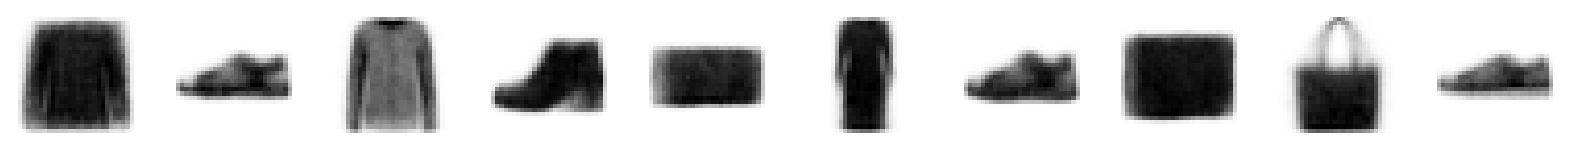

In [35]:
#Show New generated images 
display(reconstructions)

# 2. WGAN-GP model Building 🏗

In [158]:
latent_dim = 64
CHANNELS = 1
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
GP_WEIGHT = 5.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
SIZE = 32
CRITIC_LR = 0.000045 
GENERATOR_LR = 0.0002
CRITIC_STEPS = 1  


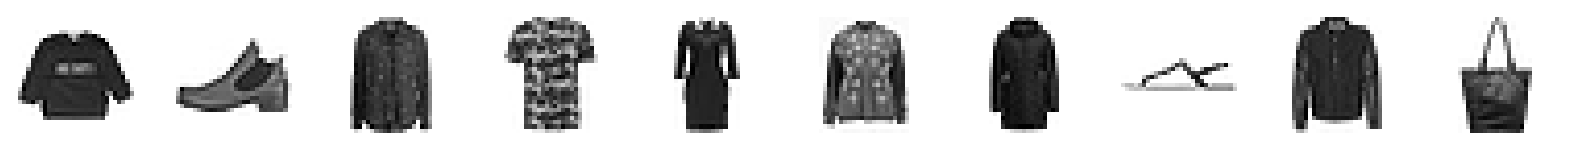

In [159]:
display(x_train)


In [160]:
critic_input = layers.Input(shape=(SIZE, SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1)(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 64)        1088      
                                                                 
 leaky_re_lu_74 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_75 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_39 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_42 (Conv2D)          (None, 4, 4, 256)         524

In [161]:

generator_input = layers.Input(shape=(latent_dim,))
x = layers.Reshape((1, 1, latent_dim))(generator_input)

# Begin with a small spatial footprint and increase size gradually
x = layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU(0.2)(x)

# Final layer to output an image of shape 32x32
x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=1, padding="same", activation="tanh")(x)

# Create the generator model
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 64)]              0         
                                                                 
 reshape_9 (Reshape)         (None, 1, 1, 64)          0         
                                                                 
 conv2d_transpose_43 (Conv2  (None, 4, 4, 256)         262144    
 DTranspose)                                                     
                                                                 
 batch_normalization_34 (Ba  (None, 4, 4, 256)         1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_44 (Conv2  (None, 8, 8, 128)         524

In [162]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        # self.history['c_loss'].append(float(self.c_loss_metric.result()))
        # self.history['c_wass_loss'].append(float(self.c_wass_loss_metric.result()))
        # self.history['c_gp'].append(float(self.c_gp_metric.result()))
        # self.history['g_loss'].append(float(self.g_loss_metric.result()))

        return {m.name: m.result() for m in self.metrics}

In [163]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=latent_dim,
    critic_steps=2,
    gp_weight=GP_WEIGHT,
)

In [164]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=CRITIC_LR, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=GENERATOR_LR, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [165]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.keras",  # Adjust the filepath as needed
    save_weights_only=False,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

training_metrics = {
    "c_loss": [],
    "c_wass_loss": [],
    "c_gp": [],
    "g_loss": []
}


class MetricsHistory(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        training_metrics['c_loss'].append(logs.get('c_loss'))
        training_metrics['c_wass_loss'].append(logs.get('c_wass_loss'))
        training_metrics['c_gp'].append(logs.get('c_gp'))
        training_metrics['g_loss'].append(logs.get('g_loss'))


metrics_history_callback = MetricsHistory()

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

        # Create the directory if it doesn't exist
        save_path = f"./generated_images/{epoch}"
        os.makedirs(save_path, exist_ok=True)

        display(
            generated_images,
            save_to=f"{save_path}/image.png",  # Change save path
            cmap=None,
        )

def scheduler(epoch, lr):
    if epoch < 1000:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = callbacks.LearningRateScheduler(scheduler)

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

# Wrap your existing dataset with this augmentation
augmented_x_train = data_augmentation(x_train)

        

Epoch 1/100
1875/1875 [==============================] - ETA: 0s - c_loss: -2.0763 - c_wass_loss: -2.5630 - c_gp: 0.0487 - g_loss: 1.7209WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


/opt/miniconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)



Saved to ./generated_images/0/image.png


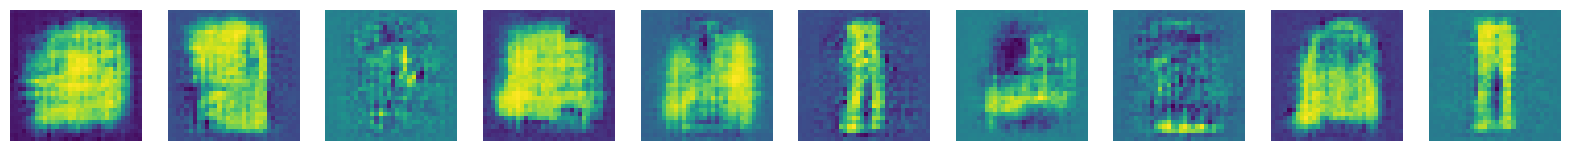

1875/1875 [==============================] - 185s 99ms/step - c_loss: -2.0763 - c_wass_loss: -2.5630 - c_gp: 0.0487 - g_loss: 1.7209 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - ETA: 0s - c_loss: -4.4564 - c_wass_loss: -5.0696 - c_gp: 0.0613 - g_loss: 6.7521WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.



Saved to ./generated_images/1/image.png


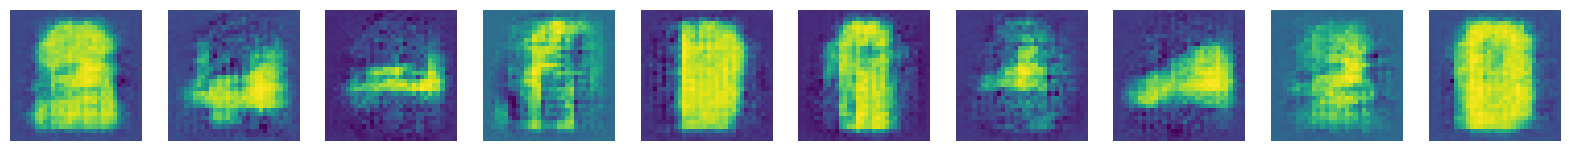

1875/1875 [==============================] - 184s 98ms/step - c_loss: -4.4564 - c_wass_loss: -5.0696 - c_gp: 0.0613 - g_loss: 6.7521 - lr: 0.0010
Epoch 3/100
1875/1875 [==============================] - ETA: 0s - c_loss: -5.2879 - c_wass_loss: -6.0922 - c_gp: 0.0804 - g_loss: 5.9080WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.



Saved to ./generated_images/2/image.png


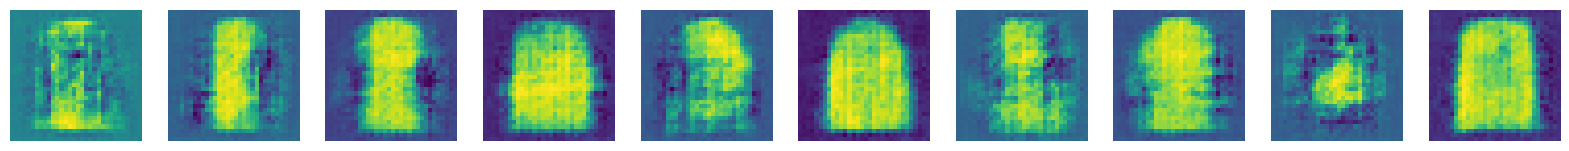

1875/1875 [==============================] - 183s 98ms/step - c_loss: -5.2879 - c_wass_loss: -6.0922 - c_gp: 0.0804 - g_loss: 5.9080 - lr: 0.0010
Epoch 4/100
1709/1875 [==========================>...] - ETA: 16s - c_loss: -5.7452 - c_wass_loss: -6.6545 - c_gp: 0.0909 - g_loss: 5.6527

KeyboardInterrupt: 

In [168]:
steps_per_epoch = len(x_train) // BATCH_SIZE  

wgangp.fit(
    augmented_x_train,  # If you decide to use augmented data
    epochs=10000,
    batch_size=32,
    steps_per_epoch=steps_per_epoch,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=latent_dim),
        metrics_history_callback,
        lr_scheduler
    ],
)

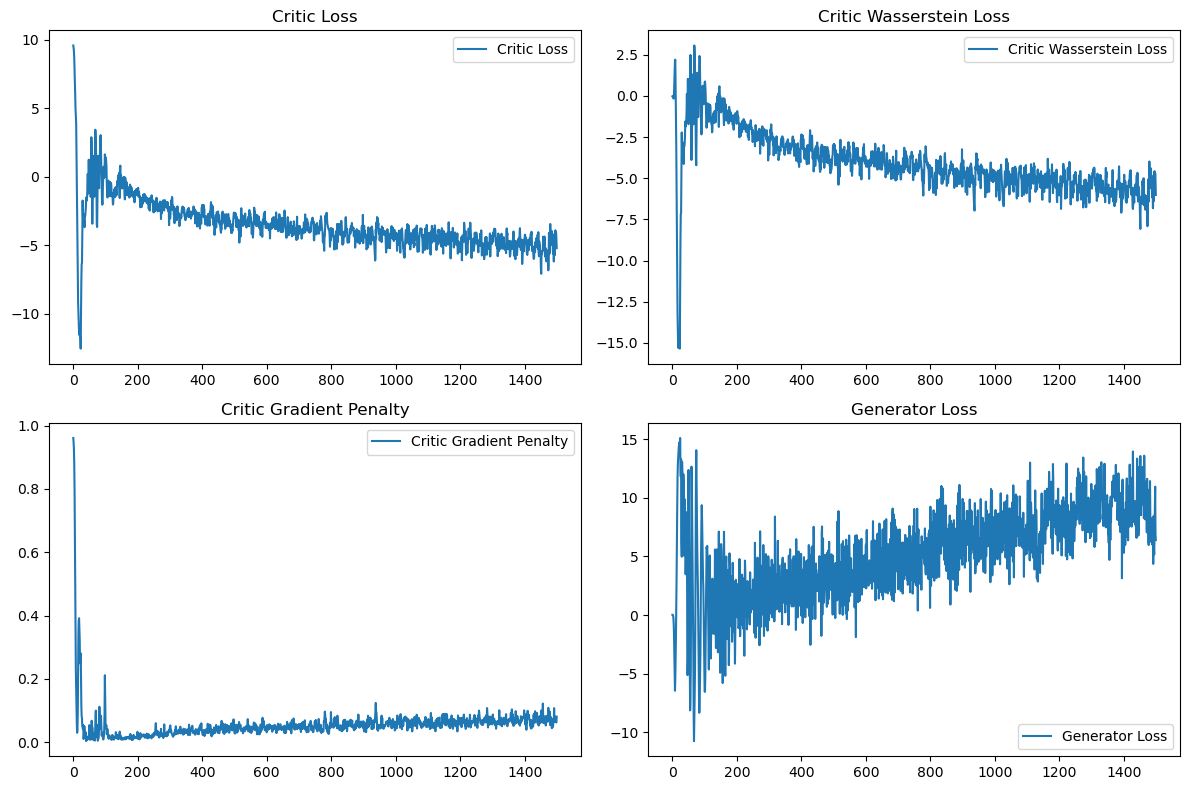

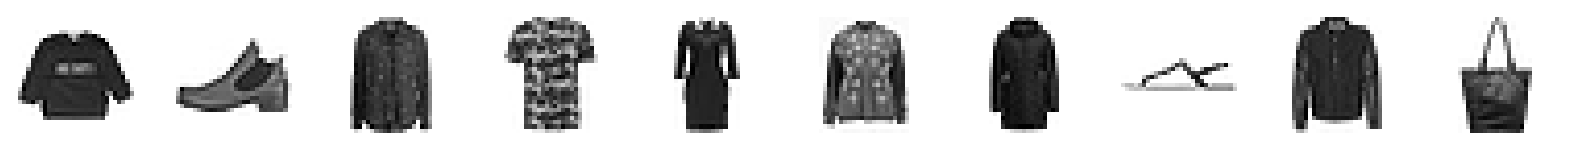

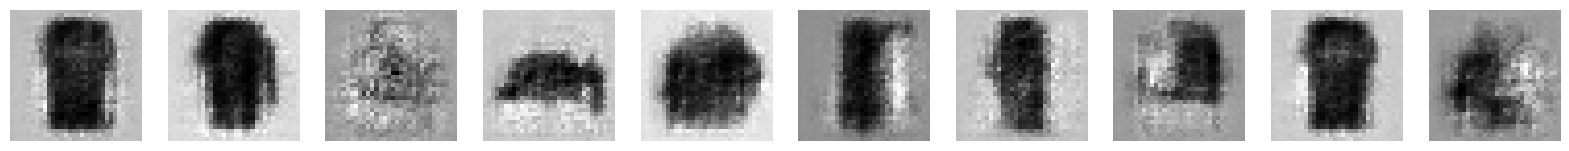

In [130]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(training_metrics['c_loss'], label='Critic Loss')
plt.title('Critic Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(training_metrics['c_wass_loss'], label='Critic Wasserstein Loss')
plt.title('Critic Wasserstein Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(training_metrics['c_gp'], label='Critic Gradient Penalty')
plt.title('Critic Gradient Penalty')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(training_metrics['g_loss'], label='Generator Loss')
plt.title('Generator Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Displaying Reconstructions
num_images_to_display = 10
random_latent_vectors = tf.random.normal(shape=(num_images_to_display, latent_dim))
generated_images = wgangp.generator(random_latent_vectors)
display(x_train)
display(generated_images.numpy())

# NOT FINISHED YET ⏰